In [1]:
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import SVD_Helper  # Assuming you have a custom module named SVD_Helper

# Load the dataset
df_songs = pd.read_csv("10000.txt", sep="\t", nrows=10000, names=['user', 'song', 'play_count'], header=None)

# Create a dictionary to store user play counts
users_play_count_dict = defaultdict(int)
with open("10000.txt", "r") as song_file:
    for record in song_file:
        user = record.split("\t")[0]
        play_count = int(record.split("\t")[2])
        users_play_count_dict[user] += play_count

# Create a DataFrame for user play counts
user_play_count_list = [{'user': u, 'play_count': p} for u, p in users_play_count_dict.items()]
df_user_play_count = pd.DataFrame(user_play_count_list)
df_user_play_count = df_user_play_count.sort_values(by='play_count', ascending=False)
df_user_play_count.to_csv("user_play_count.csv", index=None)

# Calculate the percentage of play count for the top 100,000 users
total_play_count = sum(df_user_play_count.play_count)
percentage_play_count = (float(df_user_play_count.head(n=100000).play_count.sum()) / total_play_count) * 100
df_user_subset = df_user_play_count.head(n=100000)

# Repeat a similar process for songs
songs_play_count_dict = defaultdict(int)
with open("10000.txt", "r") as song_file:
    for record in song_file:
        song = record.split("\t")[1]
        play_count = int(record.split("\t")[2])
        songs_play_count_dict[song] += play_count

song_play_count_list = [{'song': s, 'play_count': p} for s, p in songs_play_count_dict.items()]
df_song_play_summary = pd.DataFrame(song_play_count_list)
df_song_play_summary = df_song_play_summary.sort_values(by='play_count', ascending=False)
df_song_play_summary.to_csv("songs_summary.csv", index=None)

percentage_song_play_count = (float(df_song_play_summary.head(n=30000).play_count.sum()) / total_play_count) * 100
df_song_play_count_subset = df_song_play_summary.head(n=30000)

# Load the full dataset
df_all_songs = pd.read_csv("10000.txt", sep="\t", names=['user', 'song', 'play_count'], header=None)

# Filter records for the top 40% users and top 30,000 songs
df_songs_top_users = df_all_songs[df_all_songs.user.isin(list(df_user_subset.user))]
df_songs_top_songs = df_songs_top_users[df_songs_top_users.song.isin(list(df_song_play_count_subset.song))]

# Save the top 30,000 songs dataset to a file
df_songs_top_songs.to_csv("top_songs_subset.csv", index=False)

# Merge with track metadata
df_track_metadata_sub = pd.read_csv('song_data.csv', error_bad_lines=False)
df_track_metadata_sub.drop_duplicates(['song_id'], inplace=True)
df_popular_song_metadata_merged = pd.merge(df_songs_top_songs, df_track_metadata_sub, how="left",
                                           left_on="song", right_on="song_id")
df_popular_song_metadata_merged = df_popular_song_metadata_merged[['user', 'song', 'title',
                                                                   'play_count', 'release', 'artist_name', 'year']]

def create_popularity_recommendation(song_data, user_col, song_col):
    song_data_grouped = song_data.groupby([song_col]).agg({user_col: 'count'}).reset_index()
    song_data_grouped.rename(columns={user_col: 'score'}, inplace=True)

    song_data_sorted = song_data_grouped.sort_values(['score', song_col], ascending=[0, 1])
    song_data_sorted['Rank'] = song_data_sorted['score'].rank(ascending=0, method='first')

    popularity_based_recommendations = song_data_sorted.head(10)
    return popularity_based_recommendations

# Example of usage
recommendations = create_popularity_recommendation(df_popular_song_metadata_merged, 'user', 'title')

# Aggregate by user and calculate sum of all songs listened by a user
df_popular_song_metadata_merged_sum = df_popular_song_metadata_merged[['user', 'play_count']].groupby('user').sum().reset_index()
df_popular_song_metadata_merged_sum.rename(columns={'play_count': 'total_play_count'}, inplace=True)
df_popular_song_metadata_merged = pd.merge(df_popular_song_metadata_merged, df_popular_song_metadata_merged_sum)
df_popular_song_metadata_merged['fractional_play_count'] = df_popular_song_metadata_merged['play_count'] / df_popular_song_metadata_merged['total_play_count']

# Examine the structure of the newly formed dataset
df_popular_song_metadata_merged.head()

# Convert user and song IDs to integer values
user_codes_unique = df_popular_song_metadata_merged.user.drop_duplicates().reset_index()
song_codes_unique = df_popular_song_metadata_merged.song.drop_duplicates().reset_index()
user_codes_unique.rename(columns={'index': 'user_index'}, inplace=True)
song_codes_unique.rename(columns={'index': 'song_index'}, inplace=True)
song_codes_unique['so_index_value'] = list(song_codes_unique.index)
user_codes_unique['us_index_value'] = list(user_codes_unique.index)
df_popular_song_metadata_merged = pd.merge(df_popular_song_metadata_merged, song_codes_unique, how='left')
df_popular_song_metadata_merged = pd.merge(df_popular_song_metadata_merged, user_codes_unique, how='left')
matrix_candidate = df_popular_song_metadata_merged[['us_index_value', 'so_index_value', 'fractional_play_count']]
data_array_matrix = matrix_candidate.fractional_play_count.values
row_array_matrix = matrix_candidate.us_index_value.values
col_array_matrix = matrix_candidate.so_index_value.values

/var/folders/r5/q3_s72zx0l51fwvq5v135hjr0000gn/T/ipykernel_79208/2514057257.py:56: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_track_metadata_sub = pd.read_csv('song_data.csv', error_bad_lines=False)


In [2]:
df_user_play_count.head()

,user,play_count
74464,4be305e02f4e72dad1b8ac78e630403543bab994,4426
30480,6d625c6557df84b60d90426c0116138b617b9449,3482
47085,d13609d62db6df876d3cc388225478618bb7b912,2686
62196,0b19fe0fad7ca85693846f7dad047c449784647e,2679
7963,283882c3d18ff2ad0e17124002ec02b847d06e9a,2306


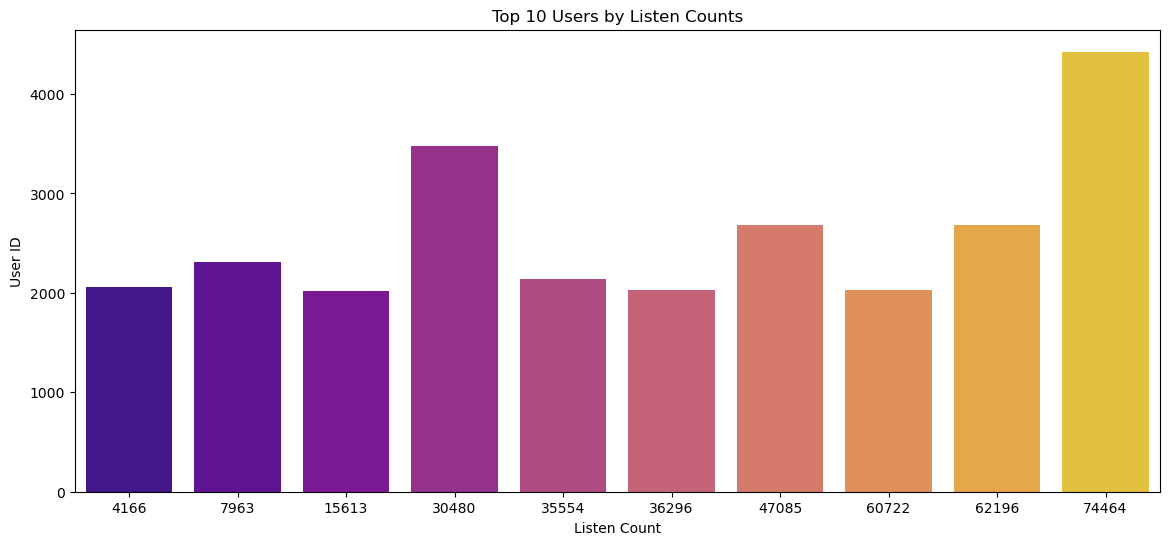

                                           user  play_count
74464  4be305e02f4e72dad1b8ac78e630403543bab994        4426
30480  6d625c6557df84b60d90426c0116138b617b9449        3482
47085  d13609d62db6df876d3cc388225478618bb7b912        2686
62196  0b19fe0fad7ca85693846f7dad047c449784647e        2679
7963   283882c3d18ff2ad0e17124002ec02b847d06e9a        2306
35554  083a2a59603a605275107c00812a811526c2a0af        2142
4166   6a944bfe30ae8d6b873139e8305ae131f1607d5f        2062
60722  5ea608df0357ec4fda191cb9316fe8e6e65e3777        2032
36296  9c859962257112ad523f1d3c121d35191daa6d2b        2032
15613  2231cb435771a1a621ec44e95cdd28b81fad3288        2019


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(14, 6))
top_users = df_user_play_count.sort_values(by='play_count', ascending=False)[:10]
sns.barplot(x=top_users.index, y=top_users.play_count, palette='plasma')  # Use orient='h' for horizontal bars
plt.title('Top 10 Users by Listen Counts')
plt.xlabel('Listen Count')
plt.ylabel('User ID')
plt.show()

print(top_users)

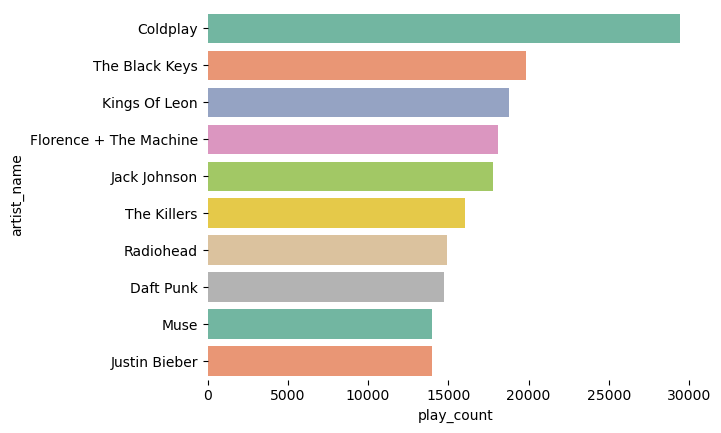

In [4]:
pop_artists_top_ten = df_popular_song_metadata_merged.groupby(['artist_name'])['play_count'].count().reset_index().sort_values(['play_count', 'artist_name'], ascending=[0, 1])
pop_artists_top_ten = pop_artists_top_ten[:10]
# Create a bar plot for the ten most popular artists
plt.figure()
sns.barplot(x=pop_artists_top_ten['play_count'], y=pop_artists_top_ten['artist_name'], palette='Set2')
sns.despine(left=True, bottom=True)

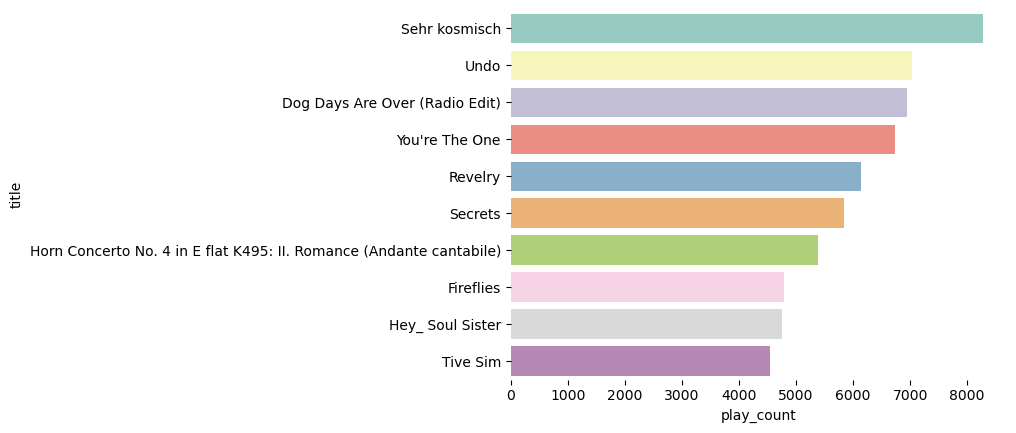

In [5]:
pop_songs_top_ten = df_popular_song_metadata_merged.groupby('title')['play_count'].count().reset_index().sort_values(['play_count', 'title'], ascending=[0, 1])
pop_songs_top_ten['percentage'] = round(pop_songs_top_ten['play_count'].div(pop_songs_top_ten['play_count'].sum()) * 100, 2)
pop_songs_top_ten = pop_songs_top_ten[:10]
plt.figure()
sns.barplot(x=pop_songs_top_ten['play_count'], y=pop_songs_top_ten['title'], palette='Set3')
sns.despine(left=True, bottom=True)

/Users/jaagruti/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


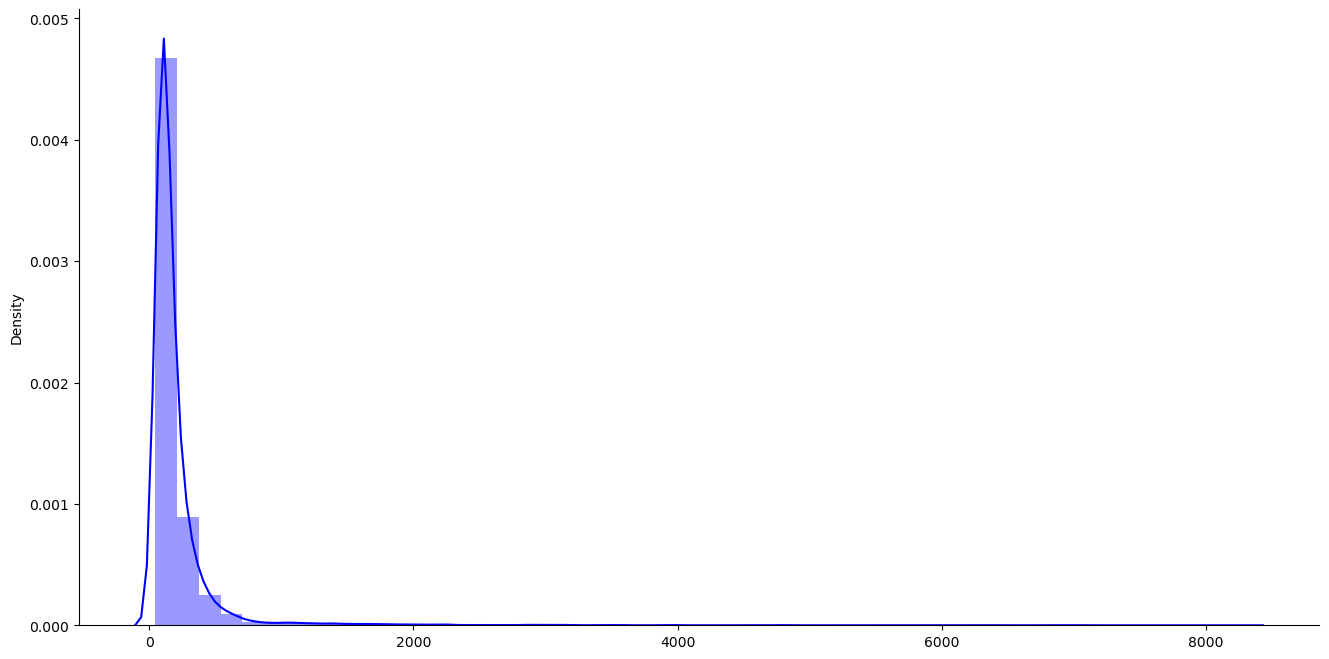

In [6]:
song_user_counts = df_popular_song_metadata_merged.groupby('song_index')['user_index'].count()

plt.figure(figsize=(16, 8))
sns.distplot(song_user_counts.values, color='blue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

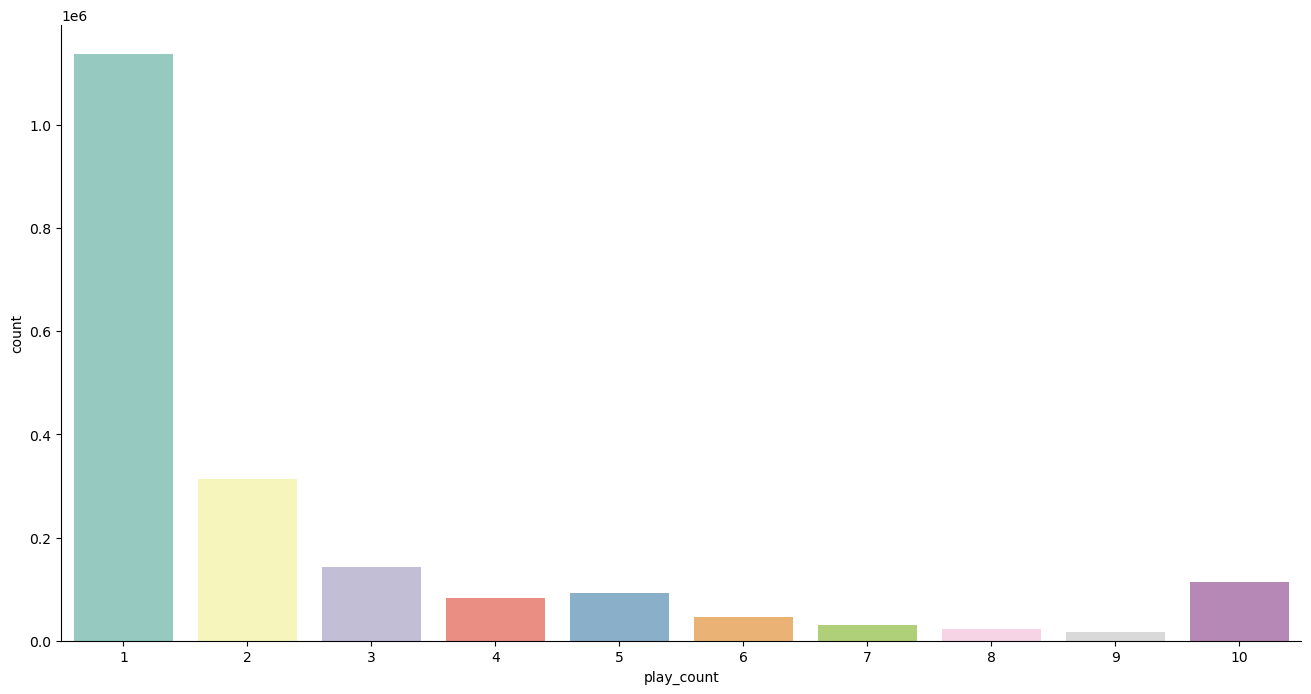

In [7]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]

df_popular_song_metadata_merged['play_count'] = pd.cut(df_popular_song_metadata_merged['play_count'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

listen_count_df = pd.DataFrame(df_popular_song_metadata_merged.groupby('play_count').size(), columns=['count']).reset_index(drop=False)

plt.figure(figsize=(16, 8))
sns.barplot(x='play_count', y='count', palette='Set3', data=listen_count_df)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [8]:
# Create a sparse matrix
sparse_data_matrix = coo_matrix((data_array_matrix, (row_array_matrix, col_array_matrix)), dtype=float)

# Example of using the SVD_Helper module
latent_features = 50
utility_matrix = sparse_data_matrix
max_product_id = utility_matrix.shape[1]
max_user_id = utility_matrix.shape[0]

U, S, Vt = SVD_Helper.compute_svd(utility_matrix, latent_features)

test_users = [74084, 74085, 74086]

recommended_items = SVD_Helper.compute_estimated_matrix(utility_matrix, U, S, Vt, test_users, latent_features, max_product_id, max_user_id, True)

for test_user in test_users:
    print("\n-------------------------------------- \
    \nRecommendation for user with id: {}\n--------------------------------------\n".format(test_user))
    rank_value = 1
    for recommended_item in recommended_items[test_user, 0:10]:
        song_details = df_popular_song_metadata_merged[df_popular_song_metadata_merged.so_index_value == recommended_item].drop_duplicates('so_index_value')[['title', 'artist_name']]
        print("#{}: {} By {}".format(rank_value, list(song_details['title'])[0], list(song_details['artist_name'])[0]))
        rank_value += 1


--------------------------------------     
Recommendation for user with id: 74084
--------------------------------------

#1: Revelry By Kings Of Leon
#2: Représente By Alliance Ethnik
#3: Ain't Misbehavin By Sam Cooke
#4: Fuck Kitty By Frumpies
#5: Almaz By Randy Crawford
#6: The Gift By Angels and Airwaves
#7: Le Jardin d'Hiver By Jacky Terrasson
#8: Billionaire [feat. Bruno Mars]  (Explicit Album Version) By Travie McCoy
#9: Creil City By Alliance Ethnik
#10: OMG By Usher featuring will.i.am

--------------------------------------     
Recommendation for user with id: 74085
--------------------------------------

#1: Almaz By Randy Crawford
#2: Sincerité Et Jalousie By Alliance Ethnik
#3: Revelry By Kings Of Leon
#4: Undo By Björk
#5: Invalid By Tub Ring
#6: All Summer Long (Album Version) By Kid Rock
#7: I Gotta Feeling By Black Eyed Peas
#8: Hey There Delilah By Plain White T's
#9: Rianna By Fisher
#10: Rio By Another Sunny Day

--------------------------------------     
Recomm